In [122]:
# importations
import numpy as np
import pandas as pd
from pyedflib import EdfReader
import mne
import EntropyHub

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy.interpolate import PchipInterpolator,interp1d

%matplotlib inline

import copy
import os
import importlib

import generisAPI
importlib.reload(generisAPI)

import generisAPI.file_operators as fp
importlib.reload(generisAPI.file_operators)

import generisAPI.data_cleaning as dcln
importlib.reload(generisAPI.data_cleaning)

import generisAPI.preprocessing as ppcn
importlib.reload(generisAPI.preprocessing)

import generisAPI.processing as pcn
importlib.reload(generisAPI.processing)

import generisAPI.audProcessing as audpcn
importlib.reload(generisAPI.audProcessing)

import generisAPI.plots as plots
importlib.reload(generisAPI.plots)

<module 'generisAPI.plots' from '/media/emmanuel/DATA/Emmanuel_petron_Olateju/github/MMN_SZ/notebooks/generisAPI/plots.py'>

### Import, compile data and preprocess

In [2]:
# definitions
electrodes=[
    'Fp1','Fp2','F3','F4','C3',
    'C4','P3','P4','O1','O2',
    'F7','F8','T3','T4','T5',
    'T6','Fz','Pz','Cz',
    ]
len(electrodes)

19

In [3]:
# compile eeg_data and annotations
subjects_dataset_root_path = '../acquired_dataset/'

data = fp.xtract_id_subject_info_dict(subjects_dataset_root_path)
print(len(data))

32


### Preprocessing

In [91]:
# assert eeg_data trials match marker trials

trialMarkerLength = dcln.assertTrialsMarkersLength()
trialMarkerLength.fit(data)
print(trialMarkerLength.indices)
clean_data = trialMarkerLength.transform(data,False)

[]


In [92]:
# check for null eeg_data

null_data_checker = dcln.nullIndicesTracer()
null_data_checker.fit(clean_data)
print(null_data_checker.indices)
clean_data = null_data_checker.transform(clean_data,True)

{'16': {'rest1': [0, 1], 'arith': [0, 1], 'rest2': [0, 1], 'auditory': [0, 1]}, '20': {'rest1': [], 'arith': [], 'rest2': [], 'auditory': [0]}, '23': {'rest1': [], 'arith': [0], 'rest2': [0], 'auditory': [0]}, '32': {'rest1': [0, 1, 2], 'arith': [0, 1, 2], 'rest2': [0, 1, 2], 'auditory': [0, 1, 2]}, '4': {'rest1': [], 'arith': [], 'rest2': [2], 'auditory': [2]}, '5': {'rest1': [0, 1], 'arith': [0, 1], 'rest2': [0, 1], 'auditory': [0, 1]}, '6': {'rest1': [], 'arith': [], 'rest2': [], 'auditory': [0]}, '8': {'rest1': [0, 1], 'arith': [0, 1], 'rest2': [0, 1], 'auditory': [0, 1]}, '9': {'rest1': [0, 1], 'arith': [0, 1], 'rest2': [0, 1], 'auditory': [0, 1]}}


In [93]:
preprocess_method=[
    [ppcn.channel_dropper,{'index':[19,20,21,22,23],'axis':0}],
    [ppcn.filter,{'lfreq':75,'hfreq':45,'sfreq':200}],
    [ppcn.filter,{'lfreq':100,'hfreq':None,'sfreq':200}],
    # [ppcn.resampler,{'up':1,'down':1}],
    [ppcn.baseline_corrector,{'with_std':False}]
]

preprocess_pipeline = ppcn.ppcn_pipeline(preprocess_method)

mne.set_log_level('ERROR')
clean_data = ppcn.all_subjects_preprocessor(
    preprocess_pipeline,
    clean_data
)

In [94]:
auditory_data = pcn.xtract_phase_data('auditory',clean_data)
arithmetic_data = pcn.xtract_phase_data('arith',clean_data)
firstRest_data = pcn.xtract_phase_data('rest1',clean_data)
secondRest_data = pcn.xtract_phase_data('rest2',clean_data)

### Auditory stimuli processing

In [127]:
aud_data = audpcn.all_subjects_phase_auditory_epochs(auditory_data,0.8)

In [128]:
aud_method=[
    [audpcn.aud_stimuli_trial_average,{}],
    [ppcn.electrode_grouper,{'electrodes':electrodes,'target':'T'}]
]

aud_pcn_pipeline = audpcn.pipeline(aud_method)

avg_aud = audpcn.all_subjects_processor(aud_pcn_pipeline,aud_data)

mmn_pcn = audpcn.stimuli_mmn(' ',5)
mmn_eeg = mmn_pcn.fit_transform(avg_aud)

### STFT Feature

In [10]:
stft_feature_method=[
    [pcn.trial_epoching,{'dummy':0}],
    [pcn.stft,{'fs':9,'sfreq':200}],
    [pcn.trial_averaging,{'axis':0,'dummy':0}],
    [ppcn.electrode_grouper,{'electrodes':electrodes,'target':'F'}],
    [pcn.trial_averaging,{'axis':0,'dummy':0}],
]

stft_feature_pipeline=ppcn.ppcn_pipeline(stft_feature_method)

firstRest_stft = pcn.all_subjects(stft_feature_pipeline,firstRest_data)
arithmetic_stft = pcn.all_subjects(stft_feature_pipeline,arithmetic_data)
secondRest_stft = pcn.all_subjects(stft_feature_pipeline,secondRest_data)
auditory_stft = pcn.all_subjects(stft_feature_pipeline,auditory_data)

/media/emmanuel/DATA/Emmanuel_petron_Olateju/github/MMN_SZ/notebooks/generisAPI/processing.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  res[i,:,:,:] = self.__stft(X[i,:,:])


1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9


### FuzzyEntropy Feature

In [11]:
# frontal electrodes
fuzzy_entropy_method=[
    [ppcn.electrode_grouper,{'electrodes':electrodes,'target':'F'}],
    [pcn.trial_epoching,{'dummy':0}],
    [pcn.trial_averaging,{}],
    [pcn.fuzzEnt,{'m':2}]
]

fuzzy_entropy_pipeline=ppcn.ppcn_pipeline(fuzzy_entropy_method)

frontal_entropies={
    'rest1':pcn.all_subjects(fuzzy_entropy_pipeline,firstRest_data),
    'arith':pcn.all_subjects(fuzzy_entropy_pipeline,arithmetic_data),
    'rest2':pcn.all_subjects(fuzzy_entropy_pipeline,secondRest_data),
    'auditory':pcn.all_subjects(fuzzy_entropy_pipeline,auditory_data)
}

1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9


In [12]:
# parietal and occipital electrodes
fuzzy_entropy_method=[
    [ppcn.electrode_grouper,{'electrodes':electrodes,'target':['P','T']}],
    [pcn.trial_epoching,{'dummy':0}],
    [pcn.trial_averaging,{}],
    [pcn.fuzzEnt,{'m':2}]
]

fuzzy_entropy_pipeline=ppcn.ppcn_pipeline(fuzzy_entropy_method)

parietal_occipital_entropies={
    'rest1':pcn.all_subjects(fuzzy_entropy_pipeline,firstRest_data),
    'arith':pcn.all_subjects(fuzzy_entropy_pipeline,arithmetic_data),
    'rest2':pcn.all_subjects(fuzzy_entropy_pipeline,secondRest_data),
    'auditory':pcn.all_subjects(fuzzy_entropy_pipeline,auditory_data)
}

1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9


In [15]:
# temporal_occipital electrodes
fuzzy_entropy_method=[
    [ppcn.electrode_grouper,{'electrodes':electrodes,'target':['T','O']}],
    [pcn.trial_epoching,{'dummy':0}],
    [pcn.trial_averaging,{}],
    [pcn.fuzzEnt,{'m':2}]
]

fuzzy_entropy_pipeline=ppcn.ppcn_pipeline(fuzzy_entropy_method)

temporal_occipital_entropies={
    'rest1':pcn.all_subjects(fuzzy_entropy_pipeline,firstRest_data),
    'arith':pcn.all_subjects(fuzzy_entropy_pipeline,arithmetic_data),
    'rest2':pcn.all_subjects(fuzzy_entropy_pipeline,secondRest_data),
    'auditory':pcn.all_subjects(fuzzy_entropy_pipeline,auditory_data)
}

1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9


In [14]:
# parietal and central electrodes
fuzzy_entropy_method=[
    [ppcn.electrode_grouper,{'electrodes':electrodes,'target':['C','P']}],
    [pcn.trial_epoching,{'dummy':0}],
    [pcn.trial_averaging,{}],
    [pcn.fuzzEnt,{'m':2}]
]

fuzzy_entropy_pipeline=ppcn.ppcn_pipeline(fuzzy_entropy_method)

parietal_central_entropies={
    'rest1':pcn.all_subjects(fuzzy_entropy_pipeline,firstRest_data),
    'arith':pcn.all_subjects(fuzzy_entropy_pipeline,arithmetic_data),
    'rest2':pcn.all_subjects(fuzzy_entropy_pipeline,secondRest_data),
    'auditory':pcn.all_subjects(fuzzy_entropy_pipeline,auditory_data)
}

1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9


### Plots

In [129]:
for s in data:
    if s not in null_data_checker.indices:
        fig,ax = plt.subplots(3,4,figsize=(12,7))
        plots.mmn_plot(ax[0,0:4],mmn_eeg[s])
        plots.stft_plot(ax[1,0],firstRest_stft[s][0],'1st Rest')
        plots.stft_plot(ax[1,1],arithmetic_stft[s][0],'Arithmetic Task')
        plots.stft_plot(ax[1,2],secondRest_stft[s][0],'2nd Rest')
        plots.stft_plot(ax[1,3],auditory_stft[s][0],'Auditory Task')
        plots.entropy_plot(ax[2,0],frontal_entropies['rest1'][s],1)
        plots.entropy_plot(ax[2,1],frontal_entropies['arith'][s],1)
        plots.entropy_plot(ax[2,2],frontal_entropies['rest2'][s],1)
        plots.entropy_plot(ax[2,3],frontal_entropies['auditory'][s],1)
        plots.entropy_plot(ax[2,0],parietal_central_entropies['rest1'][s],2)
        plots.entropy_plot(ax[2,1],parietal_central_entropies['arith'][s],2)
        plots.entropy_plot(ax[2,2],parietal_central_entropies['rest2'][s],2)
        plots.entropy_plot(ax[2,3],parietal_central_entropies['auditory'][s],2)
        plots.entropy_plot(ax[2,0],parietal_occipital_entropies['rest1'][s],3)
        plots.entropy_plot(ax[2,1],parietal_occipital_entropies['arith'][s],3)
        plots.entropy_plot(ax[2,2],parietal_occipital_entropies['rest2'][s],3)
        plots.entropy_plot(ax[2,3],parietal_occipital_entropies['auditory'][s],3)
        plots.entropy_plot(ax[2,0],temporal_occipital_entropies['rest1'][s],4)
        plots.entropy_plot(ax[2,1],temporal_occipital_entropies['arith'][s],4)
        plots.entropy_plot(ax[2,2],temporal_occipital_entropies['rest2'][s],4)
        plots.entropy_plot(ax[2,3],temporal_occipital_entropies['auditory'][s],4)
        fig.suptitle(s+':'+data[s]['category']+'_'+data[s]['name']+'_'+data[s]['sex']+'_'+str(data[s]['age']))
        fig.tight_layout(pad=1.5)
        # plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
        x0, x1, y0, y1 = plt.axis()
        # plt.axis((
        #     x0+0,
        #     x1+6,
        #     y0+0,
        #     y1+0
        # ))
        plt.ioff()
        plt.savefig('../data_analysis_results/results/'+data[s]['category']+'/'+s+'.png',format='png')

### Combine features per subject Class

In [75]:
def fuzzyEntropySubjectCombiner(entropies):
    res_control = dict().fromkeys(entropies)
    res_patient = dict().fromkeys(entropies)
    for phase in entropies:
        mean_val_patient=0
        mean_val_control=0
        for i,s in enumerate(entropies[phase]):
            if s not in null_data_checker.indices:
                if data[s]['category']=='Control':
                    mean_val_control += np.array(entropies[phase][s]).mean()
                else:
                    mean_val_patient += np.array(entropies[phase][s]).mean()
        res_control[phase] = mean_val_control/12
        res_patient[phase] = mean_val_patient/10
    return res_control, res_patient

In [ ]:
frontalEntropies = fuzzyEntropySubjectCombiner(frontal_entropies)
parietalOccipitalEntropies = fuzzyEntropySubjectCombiner(parietal_occipital_entropies)
temporalOccipitalEntropies = fuzzyEntropySubjectCombiner(temporal_occipital_entropies)
parietalCentralEntropies = fuzzyEntropySubjectCombiner(parietal_central_entropies)

Text(0.5, 1.0, 'Parietal/Central Electrodes')

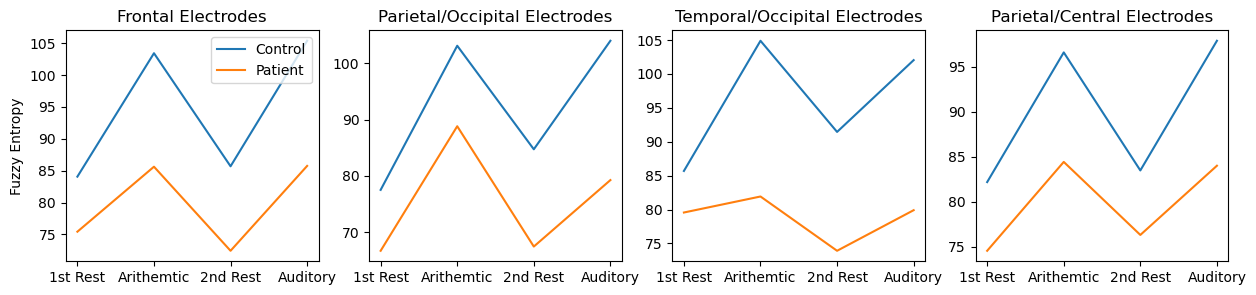

In [19]:
fig,ax = plt.subplots(1,4,figsize=(15,3))

for i,ent in enumerate([frontalEntropies,parietalOccipitalEntropies,temporalOccipitalEntropies,parietalCentralEntropies]):
    y1=[ent[0][k] for k in ent[0]]
    y2=[ent[1][k] for k in ent[1]]
    ax[i].plot(y1,label='Control')
    ax[i].plot(y2,label='Patient')
    if i==0:
        ax[i].set_ylabel("Fuzzy Entropy")
        ax[i].legend()
    ax[i].set_xticks([0,1,2,3],['1st Rest', 'Arithemtic', '2nd Rest', 'Auditory'])
ax[0].set_title('Frontal Electrodes')
ax[1].set_title('Parietal/Occipital Electrodes')
ax[2].set_title('Temporal/Occipital Electrodes')
ax[3].set_title('Parietal/Central Electrodes')

In [89]:
def mmnCombine(mmn):
    res_control=dict().fromkeys([' ','1000Hz','3000Hz'])
    res_patient=dict().fromkeys([' ','1000Hz','3000Hz'])

    for i,s in enumerate(mmn):
        tdevControl,tdevPatient=np.empty((4,20)),np.empty((4,20))
        onekControl,onekPatient=np.empty((4,20)),np.empty((4,20))
        threekControl,threekPatient=np.empty((4,20)),np.empty((4,20))
        if s not in null_data_checker.indices:
            if data[s]['category']=='Control':
                tdevControl += mmn[s][' ']
                onekControl += mmn[s]['1000Hz']
                threekControl += mmn[s]['3000Hz']
            else:
                tdevPatient += mmn[s][' ']
                onekPatient += mmn[s]['1000Hz']
                threekPatient += mmn[s]['3000Hz']
    res_control[' ']=tdevControl/12
    res_control['1000Hz']=onekControl/12
    res_control['3000Hz']=threekControl/12
    res_patient[' ']=tdevPatient/10
    res_patient['1000Hz']=onekPatient/10
    res_patient['3000Hz']=threekPatient/10
    return res_control,res_patient

In [90]:
mmns = mmnCombine(avg_aud)

Text(0.5, 0, 'Time(s)')

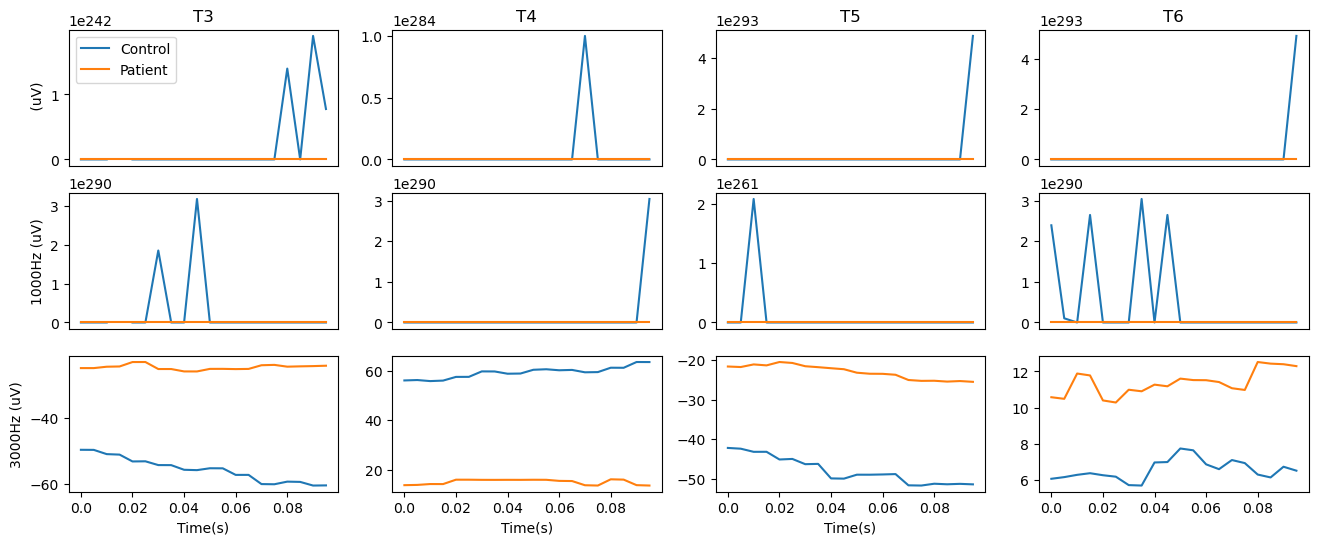

In [104]:
fig,ax = plt.subplots(3,4,figsize=(16,6))
xi=list(range(0,20,4))
x=(np.array(xi)/200).tolist()
ch=['T3','T4','T5','T6']
for r in range(3):
    ks=[' ','1000Hz','3000Hz']
    for c in range(4):
        ax[r,c].plot(mmns[0][ks[r]][c,:],label='Control')
        ax[r,c].plot(mmns[1][ks[r]][c,:],label='Patient')
        ax[r,c].set_xticks([],[])
ax[0,0].legend()
ax[0,0].set_title('T3')
ax[0,1].set_title('T4')
ax[0,2].set_title('T5')
ax[0,3].set_title('T6')
ax[2,0].set_xticks(xi,x)
ax[2,1].set_xticks(xi,x)
ax[2,2].set_xticks(xi,x)
ax[2,3].set_xticks(xi,x)
ax[0,0].set_ylabel(' (uV)')
ax[1,0].set_ylabel('1000Hz (uV)')
ax[2,0].set_ylabel('3000Hz (uV)')
ax[2,0].set_xlabel('Time(s)')
ax[2,1].set_xlabel('Time(s)')
ax[2,2].set_xlabel('Time(s)')